<a href="https://colab.research.google.com/github/Noirwolf04/pipeline_hackaton/blob/main/Mvp_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q kagglehub
# !pip install -q imbalanced-learn

# Para la descarga y manipulación general de datasets
import kagglehub
import pandas as pd
import numpy as np
import os
import joblib # Para guardar y cargar modelos/pipelines

# Librerías de Scikit-learn para preprocesamiento y modelado
from sklearn.model_selection import train_test_split # Para dividir datos en entrenamiento y prueba
from sklearn.compose import ColumnTransformer        # Para aplicar transformaciones a diferentes columnas
from sklearn.pipeline import Pipeline                # Para encadenar pasos de preprocesamiento y modelado
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Para codificación categórica y escalado numérico
from sklearn.impute import SimpleImputer             # Para manejar valores nulos
from sklearn.ensemble import RandomForestClassifier  # El modelo de clasificación Random Forest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Para evaluar el rendimiento del modelo
from sklearn.model_selection import GridSearchCV

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de imbalanced-learn para manejar desbalance de clases
from imblearn.over_sampling import SMOTE             # Para generar datos sintéticos en clases minoritarias
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline compatible con imbalanced-learn

from sklearn.base import BaseEstimator, TransformerMixin

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [ ]:
# 1. Descargar y cargar el dataset
path = kagglehub.dataset_download("radheshyamkollipara/bank-customer-churn")
# Buscamos el archivo csv en la carpeta descargada
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

# 2. Limpieza Inicial: Eliminar identificadores que no sirven para predecir
# "RowNumber" es un índice, "CustomerId" es aleatorio, "Surname" es apellido.
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Dataset cargado. Dimensiones: {df.shape}")
df.head()

Using Colab cache for faster access to the 'bank-customer-churn' dataset.
Dataset cargado. Dimensiones: (10000, 15)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [ ]:
# Creamos una variable 'HasBalance' antes de entrar al pipeline.
# Razón: Vimos en el EDA que muchos clientes tienen saldo 0.
# Esto ayuda al modelo a distinguir "Cuenta vacía" vs "Cuenta con dinero".

#df['HasBalance'] = df['Balance'].apply(lambda x: 1 if x > 0 else 0)

#print("Variable 'HasBalance' creada exitosamente.")
#df[['Balance', 'HasBalance']].head()

In [ ]:
# Definimos una clase personalizada para crear variables
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Hacemos una copia para no afectar el dataframe original
        X_out = X.copy()

        # Lógica: Si Balance > 0 es 1, si no 0
        if 'Balance' in X_out.columns:
            X_out['HasBalance'] = (X_out['Balance'] > 0).astype(int)

        # 2. Normalizar Texto (Geography y Gender)
        # Esto convierte "ALEMANIA", "alemania" -> "Alemania"
        # Asegura que coincida con el formato del entrenamiento (Title Case)
        for col in ['Geography', 'Gender']:
            if col in X_out.columns:
                # .str.title() pone la 1ra en mayúscula y resto en minúscula
                X_out[col] = X_out[col].astype(str).str.title()

        return X_out

In [ ]:
# --- DEFINICIÓN DE FEATURES ---

# 1. Numéricas: Se escalarán (StandardScaler)
# Nota: 'Balance' se mantiene porque la magnitud importa en los que tienen dinero.
NUM_FEATURES = [
    'CreditScore',
    'Age',
    'Balance',
    'NumOfProducts'
]

# 2. Categóricas: Se codificarán (OneHotEncoder)
# 'Geography' es clave (Alemania que tiene mayor porcentaje de abandino vs resto). 'Gender' aporta contexto.
CAT_FEATURES = [
    'Geography',
    'Gender'
]

# 3. Binarias / Ya listas: Pasan directo (Passthrough)
# 'IsActiveMember' es 0/1. 'HasBalance' es la nueva que creamos.
BIN_FEATURES = [
    'IsActiveMember',
    'HasBalance'
]

target = 'Exited'

print(f"Features Numéricas: {NUM_FEATURES}")
print(f"Features Categóricas: {CAT_FEATURES}")
print(f"Features Binarias: {BIN_FEATURES}")

Features Numéricas: ['CreditScore', 'Age', 'Balance', 'NumOfProducts']
Features Categóricas: ['Geography', 'Gender']
Features Binarias: ['IsActiveMember', 'HasBalance']


In [ ]:
# CONSTRUCCIÓN DEL PREPROCESADOR

preprocessor = ColumnTransformer(
    transformers=[
        # Numéricas: Imputar nulos (por si acaso) + Escalar
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), NUM_FEATURES),

        # Categóricas: Imputar nulos + One Hot Encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False para ver fácil
        ]), CAT_FEATURES),

        # Binarias: Solo dejar pasar
        ('bin', 'passthrough', BIN_FEATURES)
    ],
    remainder='drop' # IMPORTANTE: Esto elimina Complain, Salary, Tenure, etc.
)

print("Preprocessor construido.")

Preprocessor construido.


In [ ]:
#Creamos una lista de columnas de entrada que SÍ existen en el CSV.
# Excluimos 'HasBalance' porque esa se crea dentro del pipeline.
input_features = NUM_FEATURES + CAT_FEATURES + [col for col in BIN_FEATURES if col != 'HasBalance']

# 1. Separar X (Features) e y (Target)
X = df[input_features] # Filtramos solo lo útil
y = df[target]

# 2. Split Train/Test (Siempre antes de transformar para evitar fugas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 3. Construir el Pipeline de Preprocesamiento (Solo limpieza, sin modelo aún)
# OJO: Aquí usamos el FeatureGenerator que definiste antes
pipeline_preprocesamiento = Pipeline(steps=[
    ('feature_engineering', FeatureGenerator()), # <--- Paso 1: Crea HasBalance
    ('preprocessor', preprocessor)               # <--- Paso 2: Usa HasBalance (está en BIN_FEATURES)
])

# 4. Fit y Transform
# Al hacer fit, el FeatureGenerator crea la columna y luego el preprocessor la encuentra.
X_train_processed = pipeline_preprocesamiento.fit_transform(X_train)
X_test_processed = pipeline_preprocesamiento.transform(X_test)

# 5. Visualizar (Opcional)
# Recuperamos nombres. El OneHot crea nuevas columnas, el resto se mantiene.
new_cat_cols = pipeline_preprocesamiento.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(CAT_FEATURES)
# El orden de salida del ColumnTransformer suele ser: numéricas, categóricas, binarias
all_cols = NUM_FEATURES + list(new_cat_cols) + BIN_FEATURES

df_processed_view = pd.DataFrame(X_train_processed, columns=all_cols)

print(" Pipeline ejecutado exitosamente.")
print(f"Dimensiones de entrada: {X_train.shape}")
# Nota: Tendrás 1 columna más de las que entran (por HasBalance) + las del OneHot
print(f"Dimensiones de salida: {X_train_processed.shape}")
display(df_processed_view.head())

# 6. Guardar este pipeline parcial (opcional, aunque el importante es el final con modelo)
joblib.dump(pipeline_preprocesamiento, 'pipeline_preprocesamiento.joblib')

 Pipeline ejecutado exitosamente.
Dimensiones de entrada: (8000, 7)
Dimensiones de salida: (8000, 11)


,CreditScore,Age,Balance,NumOfProducts,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember,HasBalance
0,0.603488,-0.372143,-1.226957,0.806701,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.965469,-0.940679,-0.528700,-0.910597,1.0,0.0,0.0,0.0,1.0,1.0,1.0
2,1.265396,2.375783,1.109612,-0.910597,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,-0.048079,-0.940679,0.473688,-0.910597,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.251849,1.712490,-1.226957,0.806701,1.0,0.0,0.0,1.0,0.0,1.0,0.0


['pipeline_preprocesamiento.joblib']

In [ ]:
# 1. Definir el Modelo
# n_estimators=100: Usaremos 100 árboles.
# random_state=42: Para que los resultados sean reproducibles.
# class_weight='balanced': Ayuda a detectar mejor la fuga (Clase 1).
model = RandomForestClassifier(n_estimators=100,
                               random_state=42,
                               class_weight='balanced')

# 2. Crear el Pipeline Completo (Preprocesamiento + Modelo)
full_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureGenerator()),
    ('preprocessor', preprocessor), # Tu limpieza definida arriba
    ('classifier', model)           # Tu cerebro (Random Forest)
])

# 3. Entrenar el Modelo (Fit)
print("Entrenando...")
full_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenando...
Entrenamiento completado.


--- REPORTE DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1592
           1       0.71      0.50      0.59       408

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



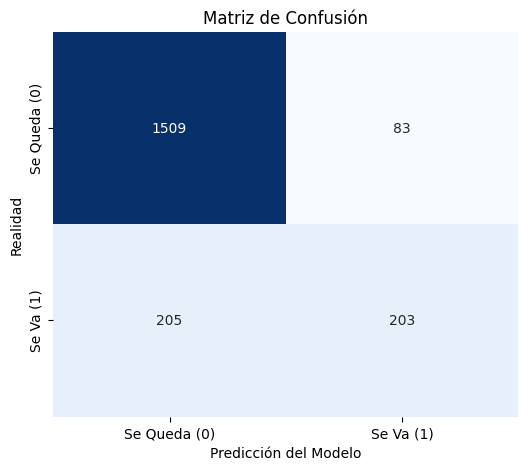

Accuracy Global: 85.60%


In [ ]:
# 1. Hacer predicciones con el set de prueba (que el modelo nunca vio)
y_pred = full_pipeline.predict(X_test)

# 2. Generar reporte de métricas
print("--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_test, y_pred))

# 3. Visualizar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['Se Queda (0)', 'Se Va (1)'])
plt.yticks([0.5, 1.5], ['Se Queda (0)', 'Se Va (1)'])
plt.show()

# Interpretación rápidai:
print(f"Accuracy Global: {accuracy_score(y_test, y_pred):.2%}")

## Umbral del 30%

--- REPORTE CON UMBRAL 0.3% ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1592
           1       0.54      0.66      0.59       408

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.83      0.81      0.82      2000



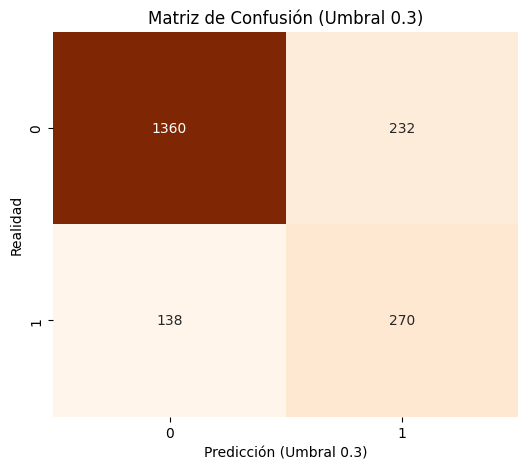

Accuracy Global: 85.60%


In [ ]:

# 1. Obtener las probabilidades en lugar de la predicción final
# Nos interesa la columna [1] que es la probabilidad de "Se Va"
y_proba = full_pipeline.predict_proba(X_test)[:, 1]
# 2. Definir nuestro nuevo umbral (Threshold)
# Bajamos la vara: Si hay más de 30% de riesgo, se va.
umbral = 0.30
y_pred_optimizado = (y_proba >= umbral).astype(int)

# 3. Evaluar con el nuevo criterio
print(f"--- REPORTE CON UMBRAL {umbral}% ---")
print(classification_report(y_test, y_pred_optimizado))

# 4. Ver la nueva Matriz de Confusión
cm_opt = confusion_matrix(y_test, y_pred_optimizado)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Oranges', cbar=False) # Color Naranja para diferenciar
plt.xlabel('Predicción (Umbral 0.3)')
plt.ylabel('Realidad')
plt.title(f'Matriz de Confusión (Umbral {umbral})')
plt.show()

# Interpretación rápidai:
print(f"Accuracy Global: {accuracy_score(y_test, y_pred):.2%}")

## Busqueda mejores parametros

In [ ]:
# 1. Definir las opciones a probar
param_grid = {
    'classifier__n_estimators': [100, 200],      # Probar con más árboles
    'classifier__max_depth': [10, 20, None],     # Limitar profundidad
    'classifier__min_samples_split': [2, 5, 10], # Exigir más datos para dividir
    'classifier__min_samples_leaf': [1, 2, 4]    # Exigir grupos mínimos más grandes
}

# 2. Configurar la Búsqueda
# cv=3: Hará validación cruzada (3 pruebas internas) para estar seguro.
# scoring='recall': Le decimos que priorice encontrar Fugas (Recall).
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1, verbose=2)

# 3. Entrenar (Esto puede tardar unos minutos)
print("Buscando los mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

# 4. Ver el Ganador
print(f"Mejores Parámetros: {grid_search.best_params_}")
print(f"Mejor Recall en Validación: {grid_search.best_score_:.2%}")

# 5. Guardar el mejor modelo encontrado
best_model = grid_search.best_estimator_

Buscando los mejores hiperparámetros...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejores Parámetros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Mejor Recall en Validación: 66.38%


--- REPORTE FINAL (MODELO OPTIMIZADO) ---
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1592
           1       0.56      0.71      0.62       408

    accuracy                           0.82      2000
   macro avg       0.74      0.78      0.75      2000
weighted avg       0.85      0.82      0.83      2000



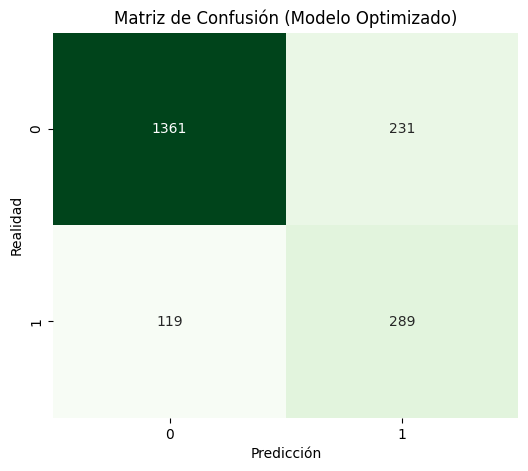

Accuracy Global: 85.60%


In [ ]:
# Evaluación del Modelo Optimizado (Best Estimator)

# 1. Extraemos el modelo ganador del GridSearch
best_model = grid_search.best_estimator_

# 2. Predecir en Test
y_pred_best = best_model.predict(X_test)

# 3. Reporte de Métricas
print("--- REPORTE FINAL (MODELO OPTIMIZADO) ---")
print(classification_report(y_test, y_pred_best))

# 4. Matriz de Confusión
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz de Confusión (Modelo Optimizado)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

# Interpretación rápidai:
print(f"Accuracy Global: {accuracy_score(y_test, y_pred):.2%}")

 Generando datos sintéticos y entrenando...
--- REPORTE FINAL (SMOTE) ---
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1592
           1       0.53      0.74      0.62       408

    accuracy                           0.82      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.82      0.83      2000



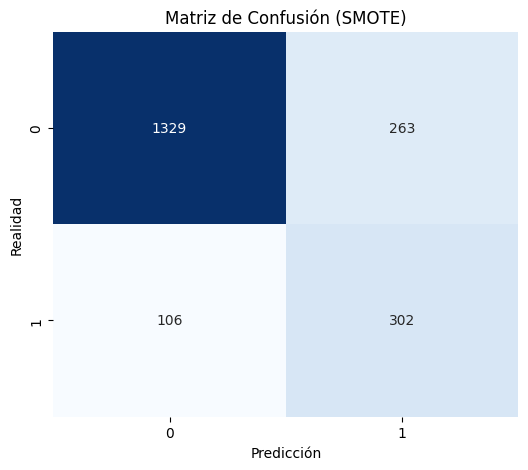

Accuracy Global: 85.60%


In [ ]:


# 1. Configurar el Random Forest con los "Mejores Parámetros" que ganaron antes
# Se quita class_weight='balanced' porque SMOTE ya balanceará los datos.
model_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)

# 2. Construir el Pipeline con SMOTE en el medio
# Flujo: Limpieza -> Crear Clientes Falsos (SMOTE) -> Entrenar Modelo
pipeline_smote = ImbPipeline(steps=[
    ('feature_engineering', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model_smote)
])

# 3. Entrenar
print(" Generando datos sintéticos y entrenando...")
pipeline_smote.fit(X_train, y_train)

# 4. Evaluar
y_pred_smote = pipeline_smote.predict(X_test)

print("--- REPORTE FINAL (SMOTE) ---")
print(classification_report(y_test, y_pred_smote))

# 5. Matriz de Confusión
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (SMOTE)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

# Interpretación rápidai:
print(f"Accuracy Global: {accuracy_score(y_test, y_pred):.2%}")


In [ ]:

# Exportar modelo
joblib.dump(pipeline_smote, 'churn_model_winner.joblib')

['churn_model_winner.joblib']

#Creamos una lista de columnas de entrada que SÍ existen en el CSV.
# Excluimos 'HasBalance' porque esa se crea dentro del pipeline.
input_features = NUM_FEATURES + CAT_FEATURES + [col for col in BIN_FEATURES if col != 'HasBalance']

# 1. Separar X (Features) e y (Target)
X = df[input_features] # Filtramos solo lo útil
y = df[target]

# 2. Split Train/Test (Siempre antes de transformar para evitar fugas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Fit y Transform (Ajustar solo con Train)
# Creamos un Pipeline final que solo tiene el preprocesamiento
pipeline_final = Pipeline(steps=[('preprocessor', preprocessor)])

# Entrenamos el pipeline con X_train
X_train_processed = pipeline_final.fit_transform(X_train)
X_test_processed = pipeline_final.transform(X_test)

# 4. Convertir a DataFrame para visualizar
# Recuperamos nombres de columnas nuevas
new_cat_cols = pipeline_final.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(CAT_FEATURES)
all_cols = NUM_FEATURES + list(new_cat_cols) + BIN_FEATURES

df_processed_view = pd.DataFrame(X_train_processed, columns=all_cols)

print("Pipeline ejecutado exitosamente.")
print(f"Dimensiones de entrada: {X_train.shape}")
print(f"Dimensiones de salida (procesada): {X_train_processed.shape}")
print("\nPrimeras filas transformadas:")
display(df_processed_view.head())

# 5. Guardar el Pipeline listo para usar
joblib.dump(pipeline_final, 'pipeline_preprocesamiento.joblib')
print("\n Pipeline guardado como 'pipeline_preprocesamiento.joblib'")